In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Problem 1

In [48]:
def transition(state, a):
    outcome = []
    for i in range(1,6):
        if a == 1:
            outcome.append([0.2, min(max(0,state+i-15),200), -2*(max(state+i-15,0))-100])
        else:
            outcome.append([0.2, min(state+i,200), -2*(state+i)])          
    return outcome

In [49]:
def one_step_lookahead(state, V, discount_factor):
    A = np.zeros(2)
    for a in range(2):
        transition_P = transition(state, a)
        for prob, next_state, reward in transition_P:
            A[a] += prob * (reward + discount_factor * V[next_state])
    return A
                                


### (a) Enumeration
Plot optimal value function at time 0 versus number of customers waiting.

In [50]:
def enumeration(discount_factor=0.95, T=500):
    V_t = np.zeros(201)
    V_tplus1 = np.zeros(201)
    for t in range(T, -1, -1):
        for s in range(201):
            A = one_step_lookahead(s, V_tplus1, discount_factor)
            best_action_value = np.max(A)
            V_t[s] = best_action_value
        V_tplus1 = V_t.copy()
    return V_t

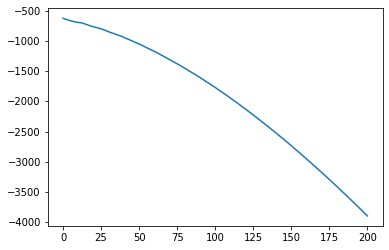

In [54]:
V_enumeration = enumeration()
plt.plot(V_enumeration)
plt.show()

### (b) Value Iteration
Plot optimal value function versus number of customers waiting.

In [51]:
def value_iteration(theta=0.001, discount_factor=0.95):
    V = np.zeros(201)
    while True:
        delta = 0
        for s in range(201):
            A = one_step_lookahead(s, V, discount_factor)
            best_action_value = np.max(A)
            delta = max(delta, np.abs(best_action_value - V[s]))
            V[s] = best_action_value
        if delta < theta:
            break
    return V
    

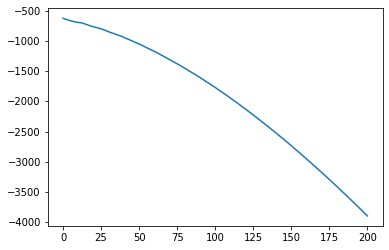

In [55]:
V_value_iteration = value_iteration()
plt.plot(V_value_iteration)
plt.show()

### (c) Policy Iteration
Plot optimal policy versus number of customers waiting.

In [52]:
def policy_eval(policy, theta=0.001, discount_factor=0.95):
    V = np.zeros(201)
    while True:
        delta = 0
        for s in range(201):
            v = 0
            for a, action_prob in enumerate(policy[s]):
                transition_P = transition(s, a)
                for prob, next_state, reward in transition_P:
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            delta = max(delta, np.abs(v-V[s]))
            V[s] = v
        if delta < theta:
            break
    return V
    
    

In [53]:
def policy_improvement(discount_factor=0.95):
    policy = np.ones([201, 2])/2
    while True:
        V = policy_eval(policy)
        policy_stable = True
        for s in range(201):
            chosen_a = np.argmax(policy[s])
            action_values = one_step_lookahead(s, V, discount_factor)
            best_a = np.argmax(action_values)
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(2)[best_a]
        
        if policy_stable:
            return policy, V
            
    

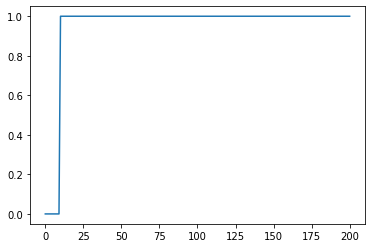

In [58]:
policy, V_policy_iteration = policy_improvement()
policy = [1 if item[1] == 1 else 0 for item in policy]
plt.plot(policy)
plt.show()

# Problem 2
Assume customers with a higher cost get on the shuttle first.

This problem has huge number of states. Because of the curse of dimensionality, it will take forever to run, which means these methods are not enough to solve problems like this.

In order to show the functionality of the functions, here we scale down all the parameters to make it solvable.

In [17]:
# number of types of customers
NUM_TYPE = 2
# max number of customers to come in each type
MAX_COME = 3
# capacity of the shuttle
SHUTTLE = 5
# cost of the shuttle
SHUTTLE_FEE = 25
# max number of waiting customers in each type
NUM_PP = 20
# cost of customers
COST = [1,1.5]
# episode to run in enumeration
T = 100

# parameters of the original setting
#NUM_TYPE = 5
#MAX_COME = 5
#SHUTTLE = 30
#SHUTTLE_FEE = 100
#NUM_PP = 10
#COST = [1,1.5,2,2.5,3]
#T = 500

# discount factor
DISCOUNT = 0.95

NUM_STATE_MULTI = (NUM_PP+1)**NUM_TYPE
ALL_STATES = [list(item) for item in list(product(range(NUM_PP+1), repeat=NUM_TYPE))]


In [18]:
def transition_multi(state, a, cost):
    next_states = np.add([list(item) for item in list(product(range(1,MAX_COME+1), repeat=NUM_TYPE))], state)
    next_states = [list(map(lambda x: min(x,NUM_PP), next_state)) for next_state in next_states]
    reward = np.zeros(len(next_states))
    for i in range(len(next_states)):
        next_state = next_states[i]
        if a == 1:
            num = 0
            type_idx = NUM_TYPE-1
            while True:
                num += next_state[type_idx]
                if num >= SHUTTLE or type_idx == 0:
                    break
                type_idx -= 1
            for j in range(NUM_TYPE-1, type_idx, -1):
                next_state[j] = 0
            next_state[type_idx] = max(0, num-SHUTTLE)
            reward[i] = -sum(np.multiply(next_state, cost))-SHUTTLE_FEE
        else:
            reward[i] = -sum(np.multiply(next_state, cost))
    prob = 1/MAX_COME**NUM_TYPE
    outcome = [[prob, next_states[i], reward[i]] for i in range(len(next_states))]       
    return outcome

In [19]:
def one_step_lookahead_multi(state, V, discount_factor, cost):
    A = np.zeros(2)
    for a in range(2):
        transition_P = transition_multi(state, a, cost)
        for prob, next_state, reward in transition_P:
            A[a] += prob * (reward + discount_factor * V[ALL_STATES.index(list(next_state))])
    return A

### (a) Enumeration
Plot optimal value function at time 0 versus number of customers waiting.

In [20]:
def enumeration_multi(discount_factor=DISCOUNT, T=T, cost=COST):
    V_t = np.zeros(NUM_STATE_MULTI)
    V_tplus1 = np.zeros(NUM_STATE_MULTI)
    for t in range(T, -1, -1):
        for s in ALL_STATES:
            A = one_step_lookahead_multi(s, V_tplus1, discount_factor, cost)
            best_action_value = np.max(A)
            V_t[ALL_STATES.index(list(s))] = best_action_value
        V_tplus1 = V_t.copy()
    return V_t

In [21]:
V_enumeration_multi = enumeration_multi()

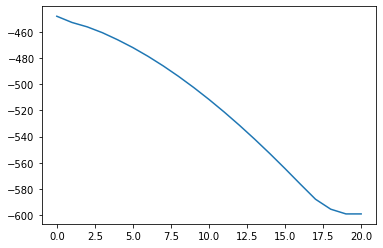

In [22]:
V_enumeration_multi_0 = [V_enumeration_multi[i] for i in range(NUM_STATE_MULTI) if ALL_STATES[i][1] == 0]
plt.plot(V_enumeration_multi_0)
plt.show()

### (b) Value Iteration
Plot optimal value function versus number of customers waiting.

In [14]:
def value_iteration_multi(theta=0.001, discount_factor=0.95, cost=COST):
    V = np.zeros(NUM_STATE_MULTI)
    while True:
        delta = 0
        for s in ALL_STATES:
            A = one_step_lookahead_multi(s, V, discount_factor, cost)
            best_action_value = np.max(A)
            delta = max(delta, np.abs(best_action_value - V[ALL_STATES.index(list(s))]))
            V[ALL_STATES.index(list(s))] = best_action_value
        if delta < theta:
            break
    return V

In [15]:
V_value_iteration_multi = value_iteration_multi()

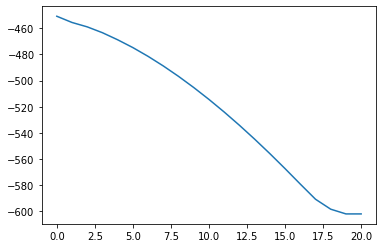

In [16]:
V_value_iteration_multi_0 = [V_value_iteration_multi[i] for i in range(NUM_STATE_MULTI) if ALL_STATES[i][1] == 0]
plt.plot(V_value_iteration_multi_0)
plt.show()

### (c) Policy Iteration
Plot optimal policy versus number of customers waiting.

In [23]:
def policy_eval_multi(policy, theta=0.001, discount_factor=0.95, cost=COST):
    V = np.zeros(NUM_STATE_MULTI)
    while True:
        delta = 0
        for s in ALL_STATES:
            v = 0
            for a, action_prob in enumerate(policy[ALL_STATES.index(list(s))]):
                transition_P = transition_multi(s, a, cost)
                for prob, next_state, reward in transition_P:
                    v += action_prob * prob * (reward + discount_factor * V[ALL_STATES.index(list(next_state))])
            delta = max(delta, np.abs(v-V[ALL_STATES.index(list(s))]))
            V[ALL_STATES.index(list(s))] = v
        if delta < theta:
            break
    return V

In [24]:
def policy_improvement_multi(discount_factor=0.95, cost=COST):
    policy = np.ones([NUM_STATE_MULTI, 2])/2
    while True:
        V = policy_eval_multi(policy)
        policy_stable = True
        for s in ALL_STATES:
            chosen_a = np.argmax(policy[ALL_STATES.index(list(s))])
            action_values = one_step_lookahead_multi(s, V, discount_factor, cost)
            best_a = np.argmax(action_values)
            if chosen_a != best_a:
                policy_stable = False
            policy[ALL_STATES.index(list(s))] = np.eye(2)[best_a] 
        if policy_stable:
            return policy, V
            

In [25]:
policy_multi, V_policy_interation_multi = policy_improvement_multi()

We plot the policy with respect to the number of customers whose cost is 1 and fix the number of customers in the other type to be 0.

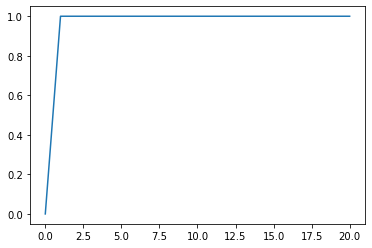

In [26]:
policy_multi = [0 if array[0] > array[1] else 1 for array in policy_multi]
policy_multi = [policy_multi[i] for i in range(NUM_STATE_MULTI) if ALL_STATES[i][1] == 0]
plt.plot(policy_multi)
plt.show()